In [1]:
import numpy as np
import cv2
import glob
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import utils

## Define a function to extract features from a list of images

In [2]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)  
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            color_t = getattr(cv2, 'COLOR_RGB2{}'.format(color_space))
            feature_image = cv2.cvtColor(image, color_t)
        else: 
            feature_image = np.copy(image)
  
        if spatial_feat == True:
            spatial_features = utils.bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = utils.color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(utils.get_hog_features(feature_image[:,:,channel], 
                                                               orient, pix_per_cell, cell_per_block, 
                                                               vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = utils.get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                      pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Read in cars and notcars

In [3]:
notcars = glob.glob('../dataset/non-vehicles/**/*.png', recursive=True)
cars = glob.glob('../dataset/vehicles/**/*.png', recursive=True)


color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (36, 36) # Spatial binning dimensions
hist_bins = 48    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Plot example of one of each of the vehicle and non-vehicle classes

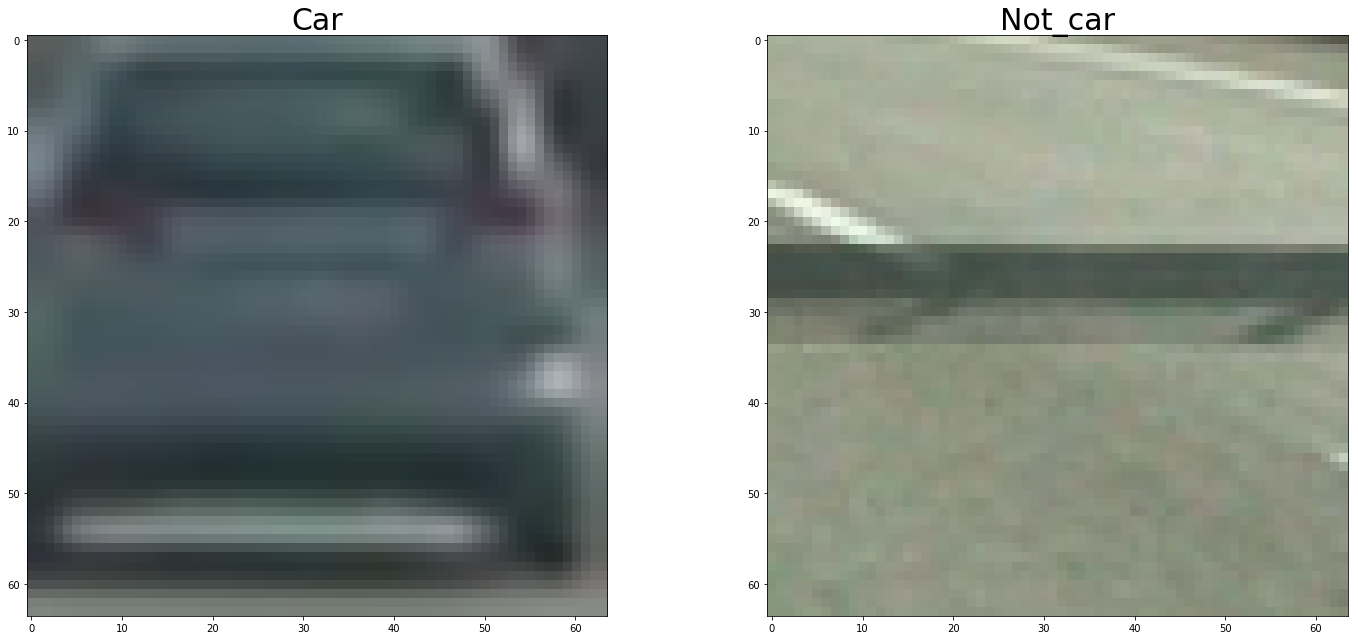

In [4]:
car_img = cv2.cvtColor(cv2.imread(cars[10]),cv2.COLOR_BGR2RGB)  
notcar_img = cv2.cvtColor(cv2.imread(notcars[213]),cv2.COLOR_BGR2RGB)  

fig = plt.figure(figsize=(21,9))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car',fontsize = 30)
plt.subplot(122)
plt.imshow(notcar_img)
plt.title('Not_car',fontsize = 30)
fig.tight_layout()

In [5]:
# Color transform
if color_space != 'RGB':
    color_t = getattr(cv2, 'COLOR_RGB2{}'.format(color_space))
    car_trans = cv2.cvtColor(car_img, color_t)
    notcar_trans = cv2.cvtColor(notcar_img, color_t)
else: 
    car_trans = np.copy(car_img)
    notcar_trans = np.copy(notcar_img)

    
# HOG image
_,car_ch1_hog = utils.get_hog_features(car_trans[:,:,0], orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, vis=True, feature_vec=True)

_,notcar_ch1_hog = utils.get_hog_features(notcar_trans[:,:,0], orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block, vis=True, feature_vec=True)

# binned color feature
car_ch1_bin = cv2.resize(car_trans[:,:,0], spatial_size)
car_ch2_bin = cv2.resize(car_trans[:,:,1], spatial_size)
car_ch3_bin = cv2.resize(car_trans[:,:,2], spatial_size)
notcar_ch1_bin = cv2.resize(notcar_trans[:,:,0], spatial_size)
notcar_ch2_bin = cv2.resize(notcar_trans[:,:,1], spatial_size)
notcar_ch3_bin = cv2.resize(notcar_trans[:,:,2], spatial_size)

# histograms of color
car_hist = utils.color_hist(car_trans, nbins=hist_bins)
notcar_hist = utils.color_hist(notcar_trans, nbins=hist_bins)

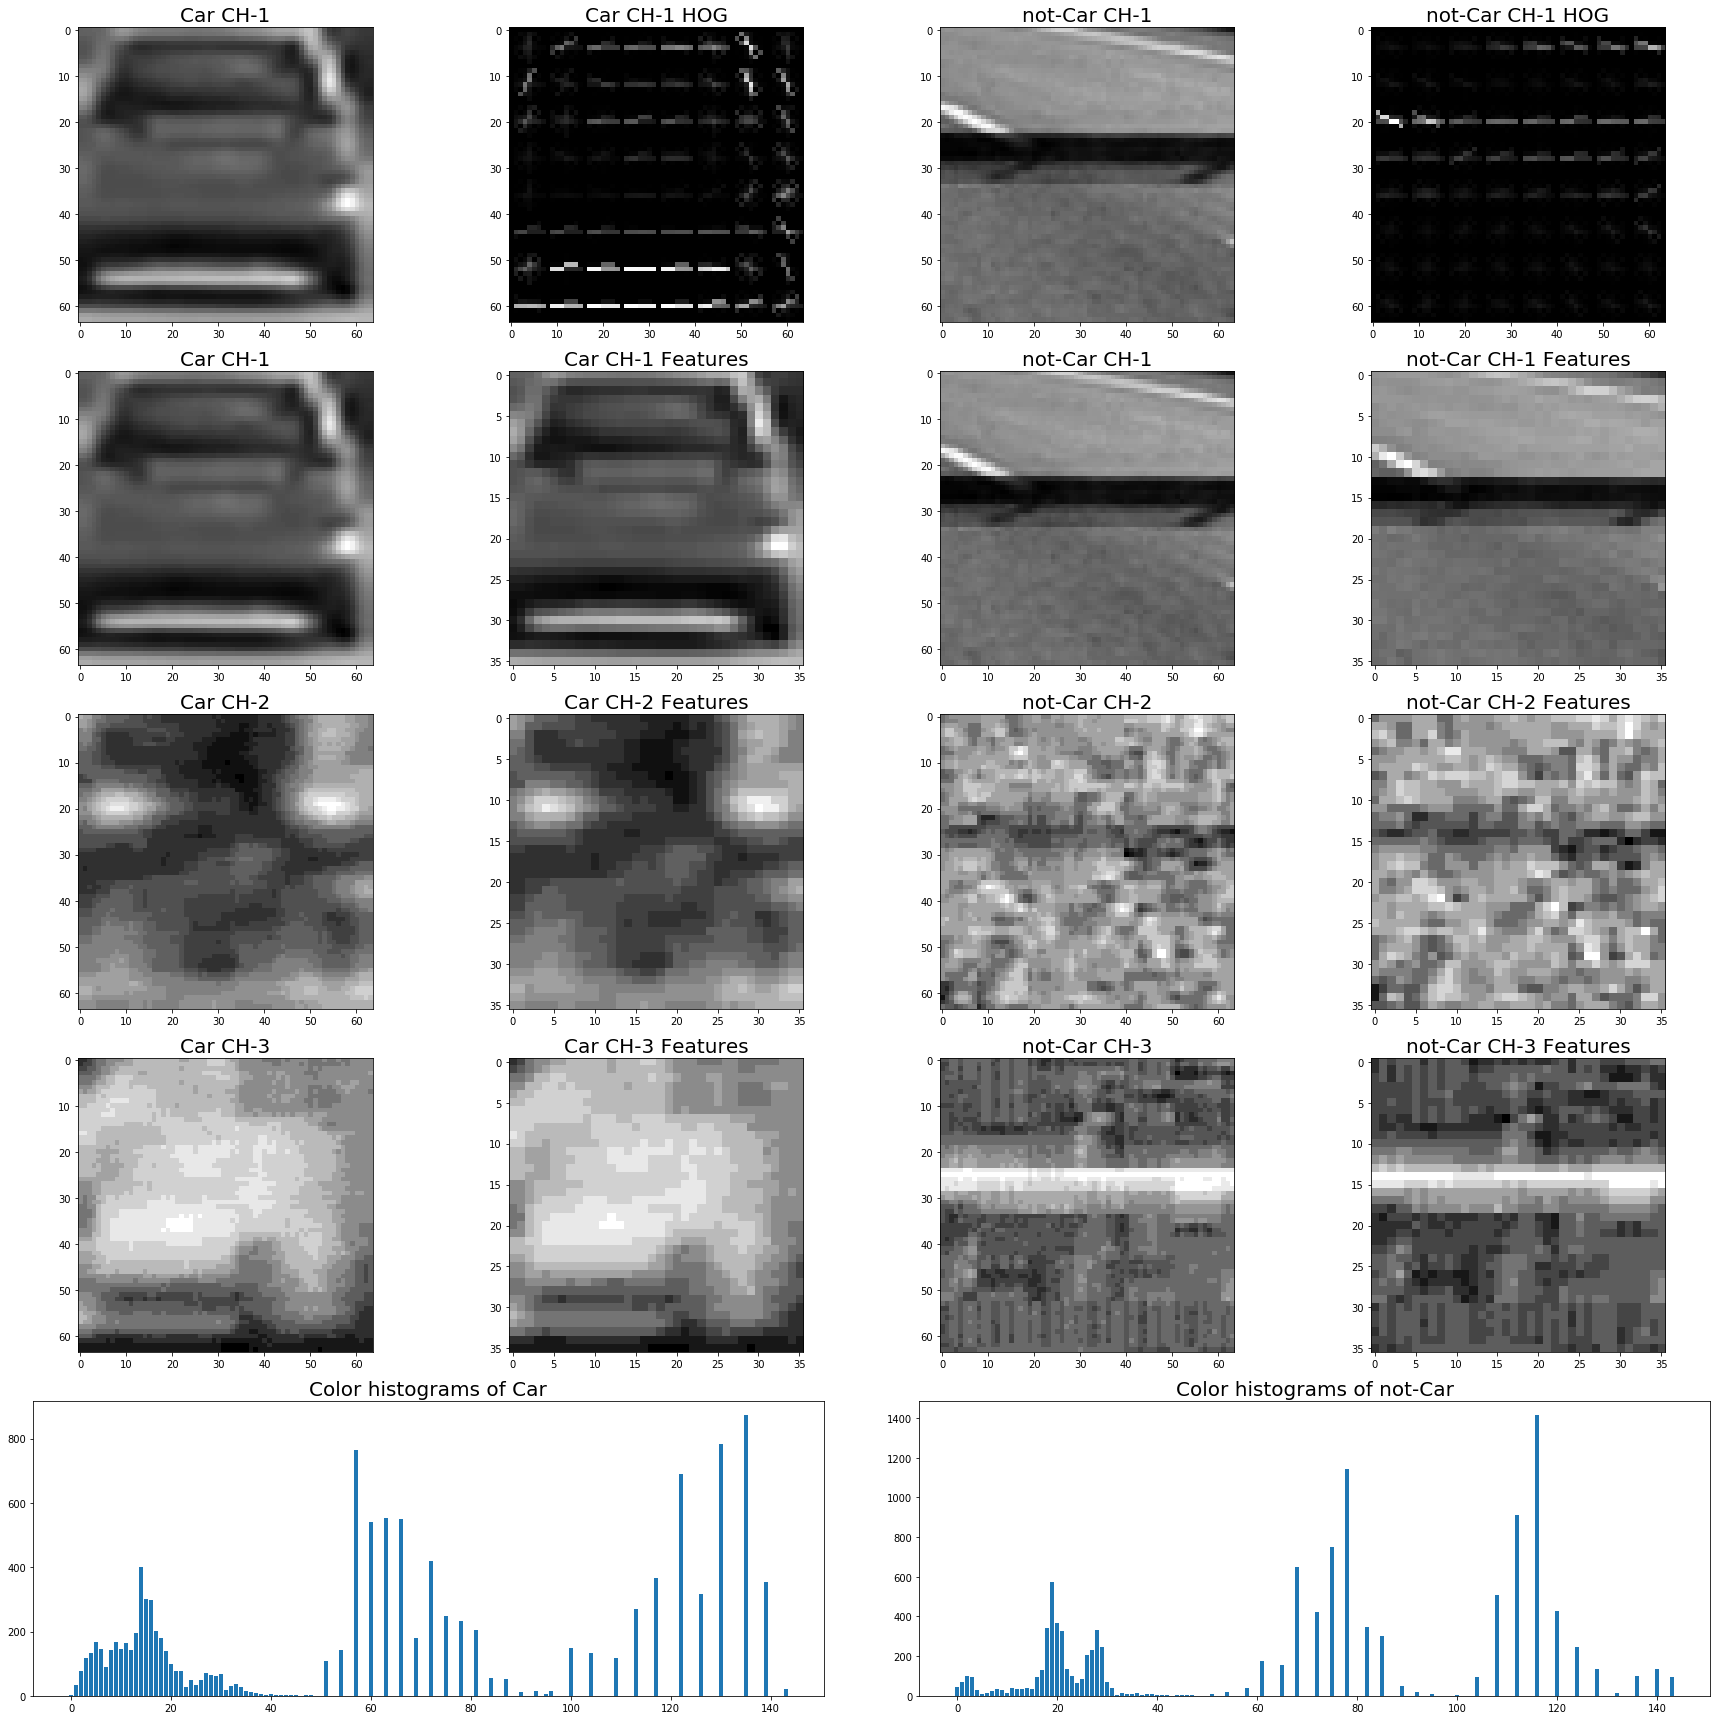

In [6]:
fig = plt.figure(figsize=(24,24))
fontsize = 20
plt.subplot(5,4,1)
plt.imshow(car_trans[:,:,0], cmap='gray')
plt.title('Car CH-1',fontsize = fontsize)
plt.subplot(5,4,2)
plt.imshow(car_ch1_hog, cmap ='gray')
plt.title('Car CH-1 HOG',fontsize = fontsize)
plt.subplot(5,4,3)
plt.imshow(notcar_trans[:,:,0], cmap='gray')
plt.title('not-Car CH-1',fontsize = fontsize)
plt.subplot(5,4,4)
plt.imshow(notcar_ch1_hog, cmap ='gray')
plt.title('not-Car CH-1 HOG',fontsize = fontsize)

plt.subplot(5,4,5)
plt.imshow(car_trans[:,:,0], cmap='gray')
plt.title('Car CH-1',fontsize = fontsize)
plt.subplot(5,4,6)
plt.imshow(car_ch1_bin, cmap ='gray')
plt.title('Car CH-1 Features',fontsize = fontsize)
plt.subplot(5,4,7)
plt.imshow(notcar_trans[:,:,0], cmap='gray')
plt.title('not-Car CH-1',fontsize = fontsize)
plt.subplot(5,4,8)
plt.imshow(notcar_ch1_bin, cmap ='gray')
plt.title('not-Car CH-1 Features',fontsize = fontsize)

plt.subplot(5,4,9)
plt.imshow(car_trans[:,:,1], cmap='gray')
plt.title('Car CH-2',fontsize = fontsize)
plt.subplot(5,4,10)
plt.imshow(car_ch2_bin, cmap ='gray')
plt.title('Car CH-2 Features',fontsize = fontsize)
plt.subplot(5,4,11)
plt.imshow(notcar_trans[:,:,1], cmap='gray')
plt.title('not-Car CH-2',fontsize = fontsize)
plt.subplot(5,4,12)
plt.imshow(notcar_ch2_bin, cmap ='gray')
plt.title('not-Car CH-2 Features',fontsize = fontsize)

plt.subplot(5,4,13)
plt.imshow(car_trans[:,:,2], cmap='gray')
plt.title('Car CH-3',fontsize = fontsize)
plt.subplot(5,4,14)
plt.imshow(car_ch3_bin, cmap ='gray')
plt.title('Car CH-3 Features',fontsize = fontsize)
plt.subplot(5,4,15)
plt.imshow(notcar_trans[:,:,2], cmap='gray')
plt.title('not-Car CH-3',fontsize = fontsize)
plt.subplot(5,4,16)
plt.imshow(notcar_ch3_bin, cmap ='gray')
plt.title('not-Car CH-3 Features',fontsize = fontsize)

plt.subplot(5,2,9)
plt.bar(range(3*hist_bins), car_hist, align='center')
plt.title('Color histograms of Car',fontsize = fontsize)
plt.subplot(5,2,10)
plt.bar(range(3*hist_bins), notcar_hist, align='center')
plt.title('Color histograms of not-Car',fontsize = fontsize)
fig.tight_layout()

## Extract features

In [7]:
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)

print('Number of car imags:', len(cars))
print('Number of not-car imags:', len(notcars))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = 1234
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Number of car imags: 8792
Number of not-car imags: 8968
Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 14616


## Train SVC

In [8]:
# Use a linear SVC 
svc = LinearSVC()
parameters = {'C':[0.0001, 0.0003, 0.01, 0.03, 0.1]}
clf = GridSearchCV(svc, parameters, n_jobs=4, cv=5, verbose=1)
clf.fit(X_train,y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.3min finished


Test Accuracy of SVC =  0.9921


In [9]:
pickle_file = 'Classifier_9921.p'
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'color_space': color_space,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat,
                'X_scaler': X_scaler,
                'clf': clf
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Classifier cached in pickle file.')

Classifier cached in pickle file.
